# Answers to the questions for Assignment 1

This notebook provides the answers to questions from *Assignment 1 -- Place cells and the basics*

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from statistics import mean
import matplotlib.patches as mpatches

from matplotlib import cycler
colors = cycler('color',['#EE6666', '#3388BB', '#9988DD','#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none', axisbelow=True, grid=True) # make gray background (by changing run time configuration, ie. default matplotlip)
plt.rc('grid', color='w', linestyle='solid') # make white grid

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


Here we define the parameters for the simulation. We will consider a 1-D environment, such as linear track

In [2]:
# variables to be systematically changed during simulation exploration:

track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording

pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

noise_firing_rate = 0.1 # the baseline noise firing rate (default: 0.1)


The probaility distribution for the place field size has shape

In [3]:
x = np.arange(0., 50., 0.1)
g = scipy.stats.gamma.pdf(x, 10) # place field size drawn from gamma distribution
# plt.plot(x, g) # visualise gamma distribution

In [4]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

Here is what the true place field maps will look like

In [5]:
#plt.imshow(true_firing_rate_maps, cmap='inferno')
#plt.xlabel('location (cm)')
#plt.ylabel('cell #')

Now plotting them in the order of place field (common plot type in the field)

In [6]:
#ix = np.argsort(pf_centers)
#plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
#plt.xlabel('location (cm)')
#plt.ylabel('cell #')
#plt.colorbar()

now let's simulate the "mouse" trajectory. The mouse will shuttle back and forth on the linear track and will stop at the two ends to eat. We will make a very rough simulation, in which the running speed will be constant for each run

In [7]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps


`t` and `x` are, respectively, the times, and position readouts for all the video frames. This pair represent the first time series that we will encounter in a typical experiment

This is what the mouse trajectory looks like

In [8]:
#plt.plot(t, x)
#plt.xlabel('Time (s)')
#plt.ylabel('position on track (cm)')

The cell below draws spikes according to an inhomogeneous Poisson process. This is the hear of the simulation. Look at the `for` loop, what is each line of code doing?

In [9]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp] # spike times of the i-th cell
    spikes.append(t_sp)

`spikes` and the pair `t, x` contain the information that we typically get from an experiment. Thus, our analyses will focus on those. 

In the lines below, we plot the positions at which the spikes are fired. 

Note two important things

- the use of `np.interp` (check the documentation!) to realign the spikes and the position time series. That instruction returns a series of the positions at which spikes were fired. This is a key operation that you will perform many times in the context of these analyses 
    - my interpretation: `np.interp(spikes[i], t, x)` takes array of spike times, finds them i t and assigns the position of the animal at that point in time
    

- the use of `interact` (from `ipywidgets`) to make an interactive plot so that we quickly explore the behavior of all cells



In [27]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.grid(False)
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

Let's extract this information directly using a typical Python construct, a _list comprehension_ (check the docs if you don't know what that is! Spoiler: it's a handy way to replace a for loop)

In [11]:
spike_positions = [np.interp(s, t, x) for s in spikes]

Now let's make experimental firing rate maps, by taking the histogram of the spikes at each position and normalizing it by the "occupancy" that is, the time at each point on the track.

In [12]:
step_size = 1. # step size is the size of a histogram bin in centimeters
space_bins = np.arange(0., 200., step_size) # arange(start, end, step_size)

# we compute histograms for each cell
spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] / fps

# frm without gaussian smoothening
firing_rate_maps = spikes_hist / occupancy


In [13]:
# applying gaussian smoother (gaussian_kde)
# alternative way to smoothen data: scipy.stats.gaussian_kde(dataset, bw_method=None, weights=None)
spikes_hist_smooth = [scipy.stats.gaussian_kde(np.array(s).T).evaluate(space_bins[:-1]) for s in spike_positions] 

# we added this because gaussian_kde normalizes values which end up being too small and produce negative bits/sec in downstream code
for i in range(n_cells):
    spikes_hist_smooth[i] *= np.sum(spikes_hist[i]) / np.sum(spikes_hist_smooth[i])
    
firing_rate_maps_smooth = spikes_hist_smooth / occupancy 


Text(0.5, 1.0, 'Un-smoothened FR map. Step size = 1')

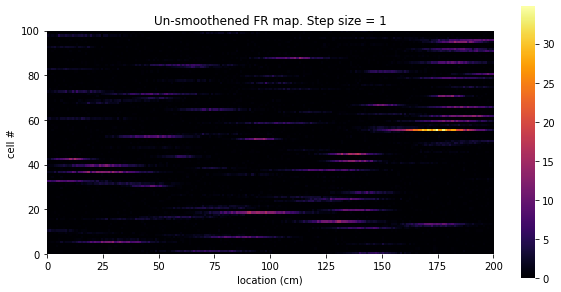

In [23]:
# FR map without gaussian smoother
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.grid(False)
plt.title('Un-smoothened FR map. Step size = %i'%step_size)

Text(0.5, 1.0, 'Smoothened FR map. Step size = 1')

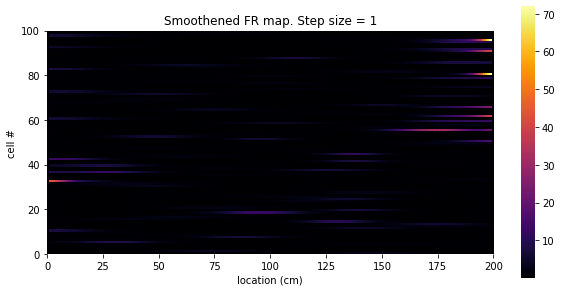

In [25]:
# FR map with gaussian smoother
plt.imshow(firing_rate_maps_smooth, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.grid(False)
plt.title('Smoothened FR map. Step size = %i'%step_size)

Text(0.5, 1.0, 'FR map of sorted place field centers. \n Un-smoothened data, Step size = 1')

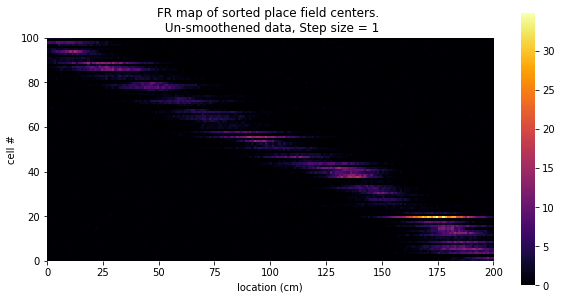

In [26]:
# sorting cells accorging to their place field centers (unsmoothened)
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.grid(False)
plt.title('FR map of sorted place field centers. \n Un-smoothened data, Step size = %i'%step_size)

## Questions

#### Question 1

Explore what happens when you change the binning in the above definition of the firing rate maps (`space_bins`). Make it coarser or broader.


#### Question 2

In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


#### Question 3 

We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. Optional: other packages such as Scikit-learn have more sophisticated kernel smoothers. Install that packages and get that smoother to run on the data


#### Question 4

When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 




In [17]:
# compute place field center with "center of mass" formula
cell_to_compare = 99; # index of cell to compare (1-100)

oneCell = spike_positions[cell_to_compare] # one s in spike_positions
oneCell_cpf = (1/len(oneCell))*np.sum(oneCell) # center of the mass   
cpf_simulated = pf_centers[cell_to_compare] # this is simulated center of place field for cell to compare

print('Simulated center of the place field:', cpf_simulated)
print('Calculated center of the place field:', oneCell_cpf)

Simulated center of the place field: 144.41525391696973
Calculated center of the place field: 134.7347019694208


## Answers 1-4

#### Answer 1: 

Numpy's function (`arange`) accepts three variables, from which the latter one is the bin size (here called `space_bins`) used for sorting spikes of each place cell. Bigger value of `space_bins` means broader bin size, i.e. we are taking bigger portion of the path to sort the detected spikes in. Such an effect can be seen on the Firing rate map where bigger bin size shows smoother place field of the cell, whereas narrower bins make place field seem grainy. However, with using smaller bin size we have higher resolution as the spikes are sorted more accurately with respect to the location on the path.


#### Answer 2:

Variable for setting the noise level is called `noise_firing_rate` and it affects number of random spike events. That is, the higher the "baseline" noise, the more non-place cell-related spikes the cell will generate. That can be seen on the Firing rate map as widening of the place fields. With the high noise levels it could be useful to use appropriate filter for "clearing" the signal. 


#### Answer 3:

Alternative approach to smoothening data, which is offered by Scipy's Gaussian smoother, was applied in following steps:
1. taking an array (s) of values which contains spike positions per cell: `np.array(s) for s in spike_positions`
2. transposing an array in a form of column vector: `np.array(s).T`
3. estimating kernel density using Gaussian_kde for that array: `scipy.stats.Gaussian_kde(np.array(s).T)`
4. evaluating estimated PDF on the set of points containing space bins, where the number of bins in `space_bins` effects the number of outputs into the matrix: `scipy.stats.Gaussian_kde(np.array(s).T).evaluate(space_bins[:-1])`

Such a smoothening technique allows for data representation with higher resolution (i.e. smaller bin size) which will not show grainy appearance (as we saw while exploring Question 1).


#### Answer 4:

The "center of mass" formula was implemented as `oneCell_cpf = (1/len(oneCell))*np.sum(oneCell)`. This line of code was used to compare calculated place field centers with simulated ones stored in an array `pf_centers`. What was seen during the comparison is that some of the value-pairs did not match, but were rather off for as much as 30 cm. One possible reason for this is that `oneCell_cpf` does not exclude high firing rates at the start and end of the running track (i.e. where the animal spends more time and thus cells emmit non-place-related spikes).

In general, making a histogram of place-cell spikes with regard to the position on the track at which they were fired will result in a distribution whose **mean** is translated as the **center of the place field**. Furthermore, **half width** of the same distribution represents **size of the place field** for that particular place-cell.

## Mutual information 

What makes a place cell? We are looking for cells with some amount of spatial selectivity. But how to we define/quantify that precisely?
One way is to use information theory. In particular mutual information is a way to quantify the degree of association between two random variables, such as the firing of an hippocampal cell and the position of a mouse. [Skaggs et al.](https://papers.nips.cc/paper/671-an-information-theoretic-approach-to-deciphering-the-hippocampal-code.pdf) defined a widely used formula to compute this "spatial information"  for the case of place cells. 

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x)}{\lambda} p_{occ}(x) $$ 



where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second. An alternative definition is expressed in bits/spike:

$$ I_s = \frac{I}{\lambda}$$ 

(same formula as above divided by average firing rate). This second definition favors low-firing rate cells (typical for place cells)

In [18]:
# mutual information
last_time_point = t[-1] # time in seconds
p_occ = occupancy / np.sum(occupancy) # probability of occupancy

for cellNumber in range(0, n_cells, 1):
    average_fr = len(spike_positions[cellNumber])/last_time_point # firing rate in hertz
    bits_per_sec = np.sum(firing_rate_maps_smooth[cellNumber] * np.log2((firing_rate_maps_smooth[cellNumber]+1.e-15)/average_firing_rate) * p_occ) # adding small value such ass 10e-15 assures avoiding zero devision
    bits_per_spike = bits_per_sec / average_fr
    #print(bits_per_sec) # values should be positive real numbers in range 0-7
    

## Questions

#### Question 5
Implement this formula, and calculate the mutual information for the cells in the simulation above

#### Question 6
Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes. 

In [19]:
def mutual_info(peak_fr=5, pfield_size=10, b_noise=0.1):
    """function returns mutual information in bits_per_second and bits_per_spike
    after varying peak firing rate, place cell size and/or baseline noise"""
    
    track_length = 200. # the length of our linear track (eg in centimeter)
    n_cells = 100 # how many cells we are recording

    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(pfield_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=peak_fr, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
    
    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
        n_runs = 20 
        
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 30 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 
    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps
    
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + b_noise
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp] # spike times of the i-th cell
        spikes.append(t_sp)
    
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., 200., 1) # arange(start, end, step_size)
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] / fps
    frm = spikes_hist / occupancy # firing rate maps
    
    # mutual information
    last_time_point = t[-1] # time in seconds
    p_occ = occupancy / np.sum(occupancy) # probability of occupancy

    all_bpsec = []
    all_bpspike = []
    for cn in range(0, n_cells, 1):
        afr = len(spike_positions[cn])/last_time_point # firing rate in hertz
        bpsec = np.sum(frm[cn] * np.log2((frm[cn]+1.e-15)/afr) * p_occ) # adding small value such ass 10e-15 assures avoiding zero devision
        bpspike = bpsec / afr
        all_bpsec.append(bpsec)
        all_bpspike.append(bpspike)
        
    return (all_bpsec, all_bpspike) 

Text(0.5, 1.0, 'Mutual Information for all simulated cells (with default values) \n Peak firing rate = 5 Hz \n Place field size = 10 \n Baseline noise = 0.1')

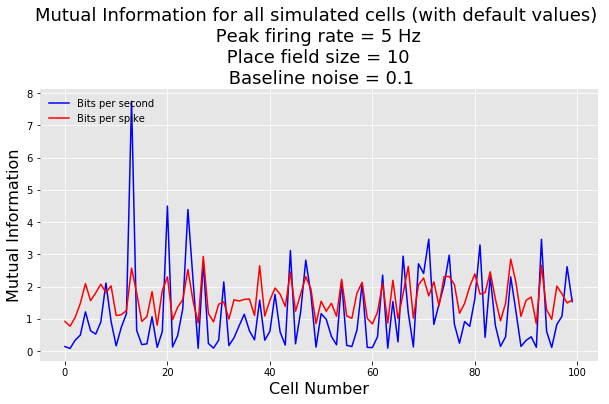

In [20]:
# mutual_info with default values
all_bps, all_bpspk = mutual_info() # mutual_info(peak_fr=5, pfield_size=10, b_noise=0.1)

plt.plot(all_bps, 'b-', label='Bits per second')
plt.plot(all_bpspk, 'r-', label='Bits per spike')
    
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Cell Number', fontsize=16)
plt.ylabel('Mutual Information', fontsize=16)
plt.title('Mutual Information for all simulated cells (with default values) \n Peak firing rate = 5 Hz \n Place field size = 10 \n Baseline noise = 0.1', fontsize=18)

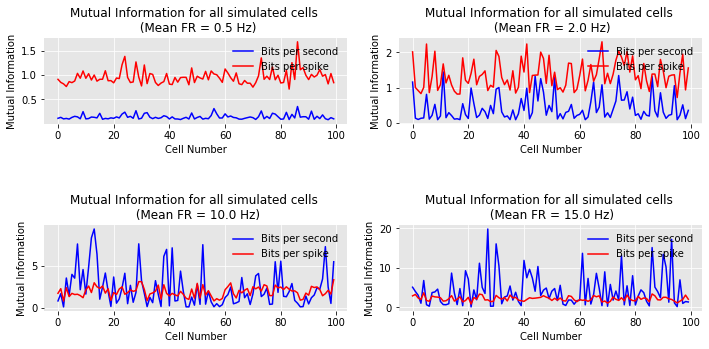

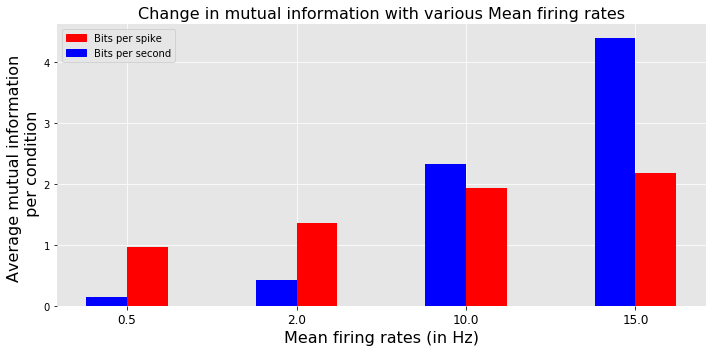

In [56]:
# vary different **firing rate** parameter options
fr_to_vary = np.array([0.5, 2, 10, 15])

fig1, ax1 = plt.subplots(2,2) # mutual information
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) # without this line, subplots have ticks with overwritten labels

fig2, ax2 = plt.subplots() # comparison of results
plt.setp(plt.gcf().get_axes(), xticks=np.arange(1,len(fr_to_vary)+1))

for ind in range (0, len(fr_to_vary), 1):
    all_bps, all_bpspk = mutual_info(peak_fr=fr_to_vary[ind]) # mutual_info(peak_fr=5, pfield_size=10, b_noise=0.1)
    lbl = ind + 1
    # subplots
    ax1 = fig1.add_subplot(2,2,lbl)
    ax1.plot(np.arange(0,n_cells,1), all_bps, 'b-', label='Bits per second') # plot all bits per sec
    ax1.plot(np.arange(0,n_cells,1), all_bpspk, 'r-', label='Bits per spike') # plot all bits per spike
    fig1.tight_layout(h_pad=3.6) # height space between subplots
    
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_xlabel('Cell Number')
    ax1.set_ylabel('Mutual Information')
    ax1.set_title('Mutual Information for all simulated cells \n (Mean FR = {} Hz)'.format(fr_to_vary[ind]))
   
    # bar plots
    w = 0.24 # bar width
    bar1 = ax2.bar((lbl)-w/2, mean(all_bps), w, color='b', label='Bits per second')
    bar2 = ax2.bar((lbl)+w/2, mean(all_bpspk), w, color='r', label='Bits per spike')
    ax2.set_ylabel('Average mutual information \n per condition', fontsize=16)
    ax2.set_xlabel('Mean firing rates (in Hz)', fontsize=16)
    
    labels = [item.get_text() for item in ax2.get_xticklabels()] # get xtick labels
    labels[ind] = '{}'.format(fr_to_vary[ind]) # specify position and new label
    ax2.set_xticklabels(labels, fontsize=12) # set new label
    
    red_patch = mpatches.Patch(color='red', label='Bits per spike')
    blue_patch = mpatches.Patch(color='blue', label='Bits per second')
    ax2.legend(handles=[red_patch, blue_patch])
    
    ax2.set_title('Change in mutual information with various Mean firing rates',fontsize=16)
    fig2.tight_layout()
    

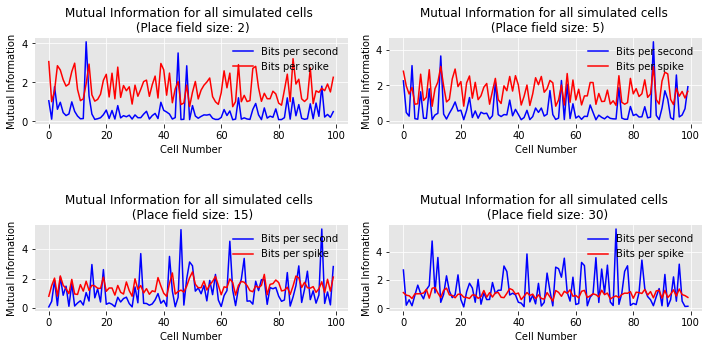

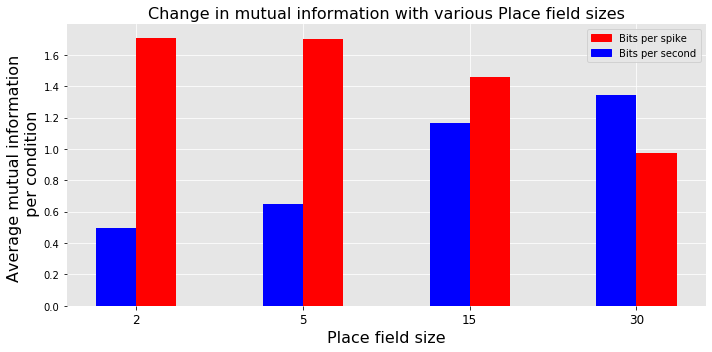

In [57]:
# vary different **place field size** parameter options
pf_size_to_vary = np.array([2, 5, 15, 30])

fig1, ax1 = plt.subplots(2,2) # mutual information
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) # without this line, subplots have ticks with overwritten labels

fig2, ax2 = plt.subplots() # comparison of results
plt.setp(plt.gcf().get_axes(), xticks=np.arange(1,len(pf_size_to_vary)+1))

for ind in range (0, len(pf_size_to_vary), 1):
    all_bps, all_bpspk = mutual_info(pfield_size=pf_size_to_vary[ind]) # mutual_info(peak_fr=5, pfield_size=10, b_noise=0.1)
    lbl = ind + 1
    # subplots
    ax1 = fig1.add_subplot(2,2,lbl)
    ax1.plot(np.arange(0,n_cells,1), all_bps, 'b-', label='Bits per second') # plot all bits per sec
    ax1.plot(np.arange(0,n_cells,1), all_bpspk, 'r-', label='Bits per spike') # plot all bits per spike
    fig1.tight_layout(h_pad=3.6) # height space between subplots
    
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_xlabel('Cell Number')
    ax1.set_ylabel('Mutual Information')
    ax1.set_title('Mutual Information for all simulated cells \n (Place field size: {})'.format(pf_size_to_vary[ind]))
   
    # bar plots
    w = 0.24 # bar width
    bar1 = ax2.bar((lbl)-w/2, mean(all_bps), w, color='b', label='Bits per second')
    bar2 = ax2.bar((lbl)+w/2, mean(all_bpspk), w, color='r', label='Bits per spike')
    ax2.set_ylabel('Average mutual information \n per condition', fontsize=16)
    ax2.set_xlabel('Place field size', fontsize=16)
    
    labels = [item.get_text() for item in ax2.get_xticklabels()] # get xtick labels
    labels[ind] = '{}'.format(pf_size_to_vary[ind]) # specify position and new label
    ax2.set_xticklabels(labels, fontsize=12) # set new label
    
    red_patch = mpatches.Patch(color='red', label='Bits per spike')
    blue_patch = mpatches.Patch(color='blue', label='Bits per second')
    ax2.legend(handles=[red_patch, blue_patch])
    
    ax2.set_title('Change in mutual information with various Place field sizes',fontsize=16)
    fig2.tight_layout()

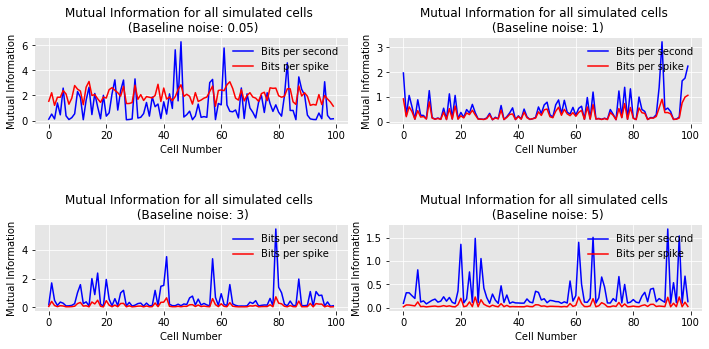

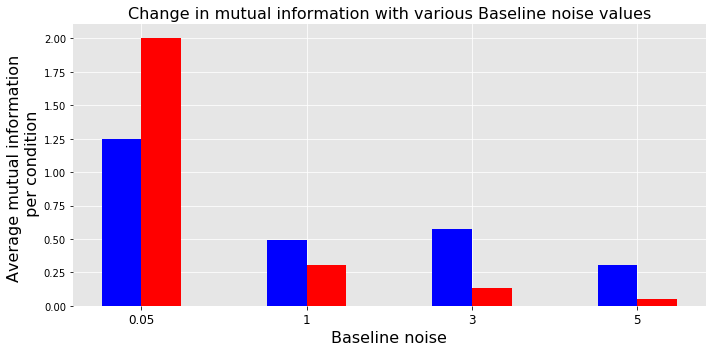

In [58]:
# vary different **baseline noise** parameter options
noise_to_vary = [0.05, 1, 3, 5]

fig1, ax1 = plt.subplots(2,2) # mutual information
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) # without this line, subplots have ticks with overwritten labels

fig2, ax2 = plt.subplots() # comparison of results
plt.setp(plt.gcf().get_axes(), xticks=np.arange(1,len(noise_to_vary)+1))

for ind in range (0, len(noise_to_vary), 1):
    all_bps, all_bpspk = mutual_info(b_noise=noise_to_vary[ind]) # mutual_info(peak_fr=5, pfield_size=10, b_noise=0.1)
    lbl = ind + 1
    # subplots
    ax1 = fig1.add_subplot(2,2,lbl)
    ax1.plot(np.arange(0,n_cells,1), all_bps, 'b-', label='Bits per second') # plot all bits per sec
    ax1.plot(np.arange(0,n_cells,1), all_bpspk, 'r-', label='Bits per spike') # plot all bits per spike
    fig1.tight_layout(h_pad=3.6) # height space between subplots
    
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_xlabel('Cell Number')
    ax1.set_ylabel('Mutual Information')
    ax1.set_title('Mutual Information for all simulated cells \n (Baseline noise: {})'.format(noise_to_vary[ind]))
   
    # bar plots
    w = 0.24 # bar width
    bar1 = ax2.bar((lbl)-w/2, mean(all_bps), w, color='b', label='Bits per second')
    bar2 = ax2.bar((lbl)+w/2, mean(all_bpspk), w, color='r', label='Bits per spike')
    ax2.set_ylabel('Average mutual information \n per condition', fontsize=16)
    ax2.set_xlabel('Baseline noise', fontsize=16)
    
    labels = [item.get_text() for item in ax2.get_xticklabels()] # get xtick labels
    labels[ind] = '{}'.format(noise_to_vary[ind]) # specify position and new label
    ax2.set_xticklabels(labels, fontsize=12) # set new label
    
    ax2.set_title('Change in mutual information with various Baseline noise values',fontsize=16)
    fig2.tight_layout()

## Answers 5-6

#### Answer 5

The formula for bits/second was implemented as:
`bits_per_sec = np.sum(firing_rate_maps_smooth[cellNumber] * np.log2((firing_rate_maps_smooth[cellNumber]+10e-15)/average_firing_rate) * p_occ)`

Mutual information was also expressed in bits/spikes: `bits_per_spike = bits_per_sec / average_firing_rate`

Both bits/sec and bits/spike yield positive real numbers which are in range between 0 and 7, or 0 and 3, respectivelly. They offer insight into mutual information between firing rate of the cell and animal's position. Larger values of bits/sec are alluding into higher correlation between cell spikes and the position we are comparing them to.

#### Answer 6

Motivated by the **Question 6**, I made a function called `mutual_info` which essentially performs the same thing as this notebook does (i.e. simualtes experimental data to explore the properties of place cells), however, it makes it easier for the user to pass in arguments which are suggested in **Question 6** to be varied.
The function accepts:
* peak firing rate (peak_fr=5),
* place field size (pfield_size=10),
* baseline noise (b_noise=0.1), 
and returns array list with *bits per second* and *bits per spike* for that condition.

After some parameter exploration, plotting means of mutual information per condition (bar plots above) showed that increase in **mean firing rate** (FR) results in higher mean bits/second values, which translates as higher information rate per second. However, simultaneously we can see the decrease in mean bits/spike value. This effect leads to conclusion that there is fewer information contained per single spike in very high FR conditions. Similar effect could be seen after increasing the **place field sizes**, since larger place field size results in overall more omitted spikes, but the valuable information per spike gets decreased. And finally, decrease in **baseline noise** level resuls high fidelity information, that is why the mean bit/spike value significantly increases. On the other hand, higher baseline noise results in lower information rate (both per second and per spike).

## Working with real data

After getting the main concepts with the simulations, we can look at some real data. You can find data from my PhD student Matteo Guardamagna at this link 
Please unzip the data contained here, you will find data from two experiments: one on a linear track (1-D, very similar to the simulations above) and one in a open field. 
the data are contained in matlab files that can be read easily using functions from scipy

Download from Brightspace the file PlaceCellsData.zip and unzip it in a folder (*outside* of your git repo). Change to this new extracted folder. In my case:

In [28]:
cd /Users/teatompos/Desktop/uni/RADBOUD/NeuroAnalysis/data/place_cells

/Users/teatompos/Desktop/uni/RADBOUD/NeuroAnalysis/data/place_cells


In [29]:
cd 1D

/Users/teatompos/Desktop/uni/RADBOUD/NeuroAnalysis/data/place_cells/1D


In [30]:
ls

default.profraw  position.mat     spiketimes.mat


We use the following method to put the spike times in the same format as for the simulations

In [31]:
f_1D = scipy.io.loadmat('spiketimes.mat')
spike_times_1D = f_1D['spike_times'] # extract spike_times from f

spikes_1D = [spike_times_1D[0][i].ravel() for i in range(len(spike_times_1D[0]))] # spike times for each cell
#print(spikes)

`spikes_1D` is now a list of numpy arrays with the spike time series 

Position data is in the file `position.mat`

In [32]:
f_1D = scipy.io.loadmat('position.mat')

and we use the following method to bring it to the same for as for the simulations

In [33]:
t_1D = f_1D['t'].ravel() # time stamps of each frame (extracted from f)
x_1D = f_1D['x'].ravel() # position of the animal in every frame (extracted from f)
sPositions_1D = [np.interp(s, t_1D, x_1D) for s in spikes_1D] # calculate spike positions at the time of each spike

Let's take a look at the data, you will see that is a much more mixed bag than the simulation: there are cells that fire little, there are interneurons (cells that fire a lot, with little spatial selectivity). The same interactive plot as above will help a lot 

In [35]:
print('Number of cells: ',len(spikes_1D))
def plot_unit(i):
    plt.plot(t_1D, x_1D)
    plt.plot(spikes_1D[i], sPositions_1D[i], 'r.')
    plt.grid(False)
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(len(spikes_1D)-1), value=0))

Number of cells:  108


interactive(children=(IntSlider(value=0, description='i', max=107), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_unit(i)>

#### Answer 7

*The code below provides results for Question 7:* 

FR map shows that some cells in the dataset spike at all locations, while the others have specific place fileds.

In [36]:
fps_1D = len(t_1D) / max(t_1D) # frames per sec for real data
print(fps_1D)

29.998455850868037


In [37]:
# firing rate maps for 1D real data
step_1D = 1.

bins_1D = np.arange(min(x_1D), max(x_1D), step_1D) # max(x) is the length of the track 
hist_1D = [np.histogram(sp, bins_1D)[0] for sp in sPositions_1D]
hist_1D = np.stack(hist_1D).astype(np.float64)
occup_1D = np.histogram(x_1D, bins_1D)[0] / fps_1D 
frm_1D = hist_1D / occup_1D

Text(0.5, 1.0, 'Sorted FR maps, Step size = 1')

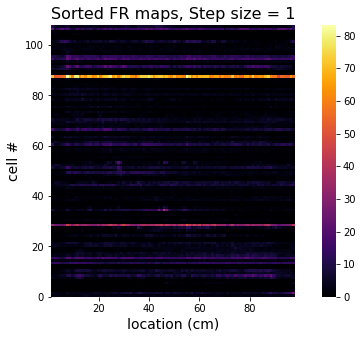

In [39]:
# unsmoothened firing rate map
pl1 = frm_1D.argmax(axis=1)
ix = np.argsort(pl1)
plt.imshow(frm_1D[ix,:], cmap='inferno', extent = [min(x_1D), max(x_1D), 0, len(spikes_1D)])
plt.xlabel('location (cm)', fontsize=14)
plt.ylabel('cell #', fontsize=14)
plt.colorbar()
plt.grid(False)
plt.title('Sorted FR maps, Step size = %i'%step_1D, fontsize=16)

#### Answer 8

*The code below provides results for Question 8:* Mutual information for 1D dataset

In [40]:
# mutual information between 1D data
endTime_1D = max(t_1D) # time in seconds
p_occup_1D = occup_1D / np.sum(occup_1D) # probability of occupancy

for cellNum in range(0, len(spikes_1D), 1):
    mean_fr_1D = len(sPositions_1D[cellNum])/endTime_1D # firing rate in hertz
    bpsec = np.sum(frm_1D[cellNum] * np.log2((frm_1D[cellNum]+1.e-15) / mean_fr_1D) * p_occup_1D) 
    bpspike = bpsec / mean_fr_1D
    
    print('Cell number:', cellNum+1)
    print('Bits per second:', bpsec)
    print('Bits per spike:', bpspike, '\n')

Cell number: 1
Bits per second: 0.290976298382784
Bits per spike: 0.24905215850084397 

Cell number: 2
Bits per second: 0.35452586975700096
Bits per spike: 0.1534813644404253 

Cell number: 3
Bits per second: 0.07658750256654676
Bits per spike: 0.14289417518063735 

Cell number: 4
Bits per second: 0.0852175363309445
Bits per spike: 0.38389112217449084 

Cell number: 5
Bits per second: 0.37960495654597287
Bits per spike: 0.09366806944606466 

Cell number: 6
Bits per second: 0.23634463434080963
Bits per spike: 0.22189236878677393 

Cell number: 7
Bits per second: 1.3233547354828379
Bits per spike: 0.33306087783174004 

Cell number: 8
Bits per second: 1.421346993899376
Bits per spike: 0.17160803714142447 

Cell number: 9
Bits per second: 0.5981667952783765
Bits per spike: 0.08685027285485349 

Cell number: 10
Bits per second: 1.4637109627741691
Bits per spike: 0.4975613853505794 

Cell number: 11
Bits per second: 0.5396886292530242
Bits per spike: 0.13693570608033226 

Cell number: 12
Bit

#### Answer 9

*The code below provides results for Question 9:* 

Data has been filtered from spikes belonging to the instances of when animal is running slower than 3 cm/s. From the newly plotted FR map, it can be seen that most of the discardes spikes correspond to the end or the beginning of the running track. That is where the animal usually spends more time sitting, so the speed is therefore below threshold.

In [41]:
# data cleanup: discarding the spikes if an animal is not running fast enough (i.e. slower than 3 cm/s)

sampling_interval = np.diff(t_1D)
ifi = sampling_interval[0] # inter-frame interval
ism = abs(np.diff(x_1D) / ifi) # instantaneous speed of the mouse

speeds = [np.interp(sp, t_1D[:-1], ism) for sp in spikes_1D] # calculate the speed at the time of each spikes

thr = 3. # speed threshold is 3 cm/s
spikes_filtered = []
for sp in range(0, len(spikes_1D), 1):
    spikes_below_thr = np.argwhere(speeds[sp] <= thr) # find indices where speed is lower than threshold
    filt = np.delete(spikes_1D[sp], spikes_below_thr) # delete spike times at which the speed was below threshold
    spikes_filtered.append(filt)
    
    print('Number of spikes deleted: ', len(spikes_1D[sp]) - len(filt))


Number of spikes deleted:  1503
Number of spikes deleted:  2844
Number of spikes deleted:  591
Number of spikes deleted:  293
Number of spikes deleted:  5153
Number of spikes deleted:  1148
Number of spikes deleted:  4920
Number of spikes deleted:  7723
Number of spikes deleted:  9947
Number of spikes deleted:  2905
Number of spikes deleted:  5204
Number of spikes deleted:  7796
Number of spikes deleted:  4397
Number of spikes deleted:  3041
Number of spikes deleted:  9262
Number of spikes deleted:  7084
Number of spikes deleted:  12071
Number of spikes deleted:  3682
Number of spikes deleted:  2337
Number of spikes deleted:  1363
Number of spikes deleted:  798
Number of spikes deleted:  600
Number of spikes deleted:  401
Number of spikes deleted:  532
Number of spikes deleted:  8614
Number of spikes deleted:  5740
Number of spikes deleted:  148
Number of spikes deleted:  357
Number of spikes deleted:  5950
Number of spikes deleted:  6365
Number of spikes deleted:  2764
Number of spike

/Users/teatompos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


In [42]:
# FR map of ** cleared ** data:

sPositions_1D_filtered = [np.interp(s, t_1D, x_1D) for s in spikes_filtered] # calculate spike positions at the time of each spike

hist_1D_filtered = [np.histogram(sp, bins_1D)[0] for sp in sPositions_1D_filtered] # use filtered sPositions
hist_1D_filtered = np.stack(hist_1D_filtered).astype(np.float64)
frm_1D_filtered = hist_1D_filtered / occup_1D


Text(0.5, 1.0, 'Sorted FR map of cleared data')

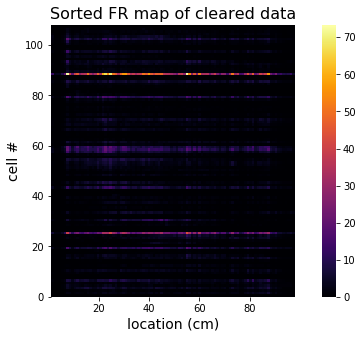

In [45]:
# FR map of ** cleared ** data:
pl2 = frm_1D_filtered.argmax(axis=1)
ix = np.argsort(pl2)
plt.imshow(frm_1D_filtered[ix,:], cmap='inferno', extent = [min(x_1D), max(x_1D), 0, len(spikes_1D)])
plt.xlabel('location (cm)',fontsize=14)
plt.ylabel('cell #',fontsize=14)
plt.colorbar()
plt.grid(False)
plt.title('Sorted FR map of cleared data',fontsize=16)

In [44]:
# mutual information between ** cleared** 1D data

for cellNum in range(0, len(spikes_1D), 1):
    mean_fr_1D_filt = len(sPositions_1D_filtered[cellNum])/endTime_1D # firing rate in hertz
    bpsec_filt = np.sum(frm_1D_filtered[cellNum] * np.log2((frm_1D_filtered[cellNum]+1.e-15)/mean_fr_1D_filt) * p_occup_1D) 
    bpspike_filt = bpsec_filt / mean_fr_1D_filt
    
    print('Cell number:', cellNum+1)
    print('Bits per second:', bpsec_filt)
    print('Bits per spike:', bpspike_filt, '\n')

Cell number: 1
Bits per second: 0.2660677264637777
Bits per spike: 0.6093175575884695 

Cell number: 2
Bits per second: 0.4903851626194324
Bits per spike: 0.5299063716961794 

Cell number: 3
Bits per second: 0.1422139729649265
Bits per spike: 0.5728171737738503 

Cell number: 4
Bits per second: 0.07287619818733829
Bits per spike: 0.918421497791206 

Cell number: 5
Bits per second: 0.7952050773293058
Bits per spike: 0.5149794542955979 

Cell number: 6
Bits per second: 0.4246159788446978
Bits per spike: 0.838700555968965 

Cell number: 7
Bits per second: 1.6620749214575308
Bits per spike: 1.0531288812114772 

Cell number: 8
Bits per second: 2.6183702951351915
Bits per spike: 0.578911987111872 

Cell number: 9
Bits per second: 0.9480534974224284
Bits per spike: 0.4635793691768319 

Cell number: 10
Bits per second: 1.2091518143093225
Bits per spike: 0.7915381100779516 

Cell number: 11
Bits per second: 0.9262446365268489
Bits per spike: 0.6579173730368956 

Cell number: 12
Bits per second:

/Users/teatompos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/teatompos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


## Questions

#### Question 7 

Reproduce the firing rate maps we produced for the simulation, in proper sorting order.

#### Question 8 

Calculate the mutual information for each cell (both bits/sec and bits/spike)

#### Question 9

Place related firing only takes place when the animal is running. When the animal is sitting still (which they do a lot as you can see from the trajectory plot), firing becomes non-local. Thus, in place cell analysis it is customary to "filter out" spikes that takes place when the animal is not running. This is a slightly tricky, but important technique. One way to do it would be to 
1. Calculate the instantaneous speed of the mouse. You can do that by calculating the time derivative of position with `np.diff` (check docs!!!), and divide by the video sampling interval (difference between two consecutive timestamps)
2. Calculate the speed at the time of each spikes. You can use `np.interp` similar to what we did to calculate position (see above)
3. Use a threshold value of ~ 3 cm/s and exclude the spikes that were emitted while the mouse was not running fast enough

After you've done this, repeat the work in questions 5 and 6 on the "cleaned up" data (it will look a lot nicer)

#### Question 10 
(optional, the trickiest of all) if you look at the interactive plot above, you will notice that many cells fire only in one direction (for example when the mouse is going from 0 to 100 and not vice versa). Calculate a directionality index as the difference between the firing rate in the place field while running in the two directions. First you need to segment time in "upwards" and "downwards" runs (that's the tricky part...) and then subset the spikes run in the two directions 

## 2D Data

Last, we will work form data recorded while the mouse was exploring a 2D environment (square box), this is contained in the `2D` directory from the same zip file. 

In [46]:
cd ../2D

/Users/teatompos/Desktop/uni/RADBOUD/NeuroAnalysis/data/place_cells/2D


In [47]:
ls

default.profraw  position.mat     spiketimes.mat


Data loading goes pretty much as in the previous case, except that now there is also a `y` position variable.

In [48]:
f_2D = scipy.io.loadmat('spiketimes.mat')
spike_times_2D = f_2D['spike_times']
spikes_2D = [spike_times_2D[0][i].ravel() for i in range(len(spike_times_2D[0]))]

f_2D = scipy.io.loadmat('position.mat')
t_2D = f_2D['t'].ravel()
x_2D = f_2D['x'].ravel()
y_2D = f_2D['y'].ravel()

This is what the mouse trajectory looks like in the arena

In [49]:
#plt.plot(x_2D, y_2D) 
#plt.axis('equal')

## Questions 

#### Question 11 
Compute the firing rate map for each cell, and use eg an interactive plot (if in a notebook) to display them all. You can use the function `np.histogram2d` 

#### Question 12 
Compute the spatial information for each cells. Explore what happens if you make the binning in your histogram too fine. You will at some point hit the so-called "finite sample size bias" problem, on which you can find more information in this paper by [Quian-Quiroga et al](https://www.nature.com/articles/nrn2578)

In [51]:
# trajectory plot
xPositions_2D = [np.interp(s, t_2D, x_2D) for s in spikes_2D] # calculate spike positions on x axis at the time of each spike
yPositions_2D = [np.interp(s, t_2D, y_2D) for s in spikes_2D] # calculate spike positions on y axis at the time of each spike

print('Number of cells: ',len(spikes_2D))
def track2d (i):
    plt.plot(x_2D, y_2D)
    plt.plot(xPositions_2D[i], yPositions_2D[i], 'r.')
    plt.grid(False)
    
interact(track2d, i = widgets.IntSlider(min=0, max=(len(spikes_2D)-1), value=0))


Number of cells:  114


interactive(children=(IntSlider(value=0, description='i', max=113), Output()), _dom_classes=('widget-interact'…

<function __main__.track2d(i)>

#### Answer 11

*The code below provides results for Question 11:*

Firing rate maps were plotted as interactive plot which allows scrolling through every cell to inspect its FR map. Number of bins was set as 50 since finer binning (i.e. higher resolution) does not provide sensible results. In order to use smaller bin size, we would need to gather much more data for the FR maps to be informative of the place fields of each cell.

In [53]:
# firing rate maps for every cell
bin2d = 50 # bin size for histograms

def hist2d (i): 
    xedges = np.arange(min(x_2D), max(x_2D), bin2d) 
    yedges = np.arange(min(y_2D), max(y_2D), bin2d)
    H, xedges, yedges = np.histogram2d(xPositions_2D[i], yPositions_2D[i], bins=(xedges, yedges))
    H = H.T # let each row list bins with common y range.
    plt.imshow(H, origin='lower',cmap='inferno',extent=[min(xedges)/bin2d, max(xedges)/bin2d, min(yedges)/bin2d, max(yedges)/bin2d])
    c_num = i+1
    plt.title('FR map of the cell %i' %c_num)
    plt.colorbar()
    plt.grid(False)
    
    plt.xlabel('%i cm bins' % bin2d)
    plt.ylabel('%i cm bins' % bin2d)

interact(hist2d, i = widgets.IntSlider(min=0, max=(len(spikes_2D)-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=113), Output()), _dom_classes=('widget-interact'…

<function __main__.hist2d(i)>

#### Answer 12

The code below provides results for Question 12

In [54]:
# spatial information for 2D data
fps_2D = len(t_2D) / max(t_2D) # frames per sec for real data
endTime_2D = max(t_2D) # time in seconds

bin2d = 50 # bin size for histograms
xedges = np.arange(min(x_2D), max(x_2D), bin2d) 
yedges = np.arange(min(y_2D), max(y_2D), bin2d)

hist_flat = [] # all flattened histograms (for every cell)
for cls in range(0, len(spikes_2D)-1,1):
    H, xedg, yedg = np.histogram2d(xPositions_2D[cls], yPositions_2D[cls], bins=(xedges, yedges))
    one_flat_hist = np.matrix.flatten(H)
    hist_flat.append(one_flat_hist)
    
occup_2D = np.histogram2d(x_2D, y_2D, bins=(xedges, yedges))[0] / fps_2D
occup_2D_flat = np.matrix.flatten(occup_2D)
p_occup_2D = occup_2D_flat / np.sum(occup_2D_flat)

all_bps2D = []
all_bpspk2D = []
for cls in range(0, len(spikes_2D)-1,1):
    mean_fr_2D = len(xPositions_2D[cls]) / endTime_2D
    bpsec_2D = np.sum(hist_flat[cls] * np.log2((hist_flat[cls]+1.e-15) / mean_fr_2D) * p_occup_2D) 
    bpspike_2D = bpsec_2D / mean_fr_2D
    
    all_bps2D.append(bpsec_2D)
    all_bpspk2D.append(bpspike_2D)
    #print('Cell number:', cls+1)
    #print('Bits per second:', bpsec_2D)
    #print('Bits per spike:', bpspike_2D, '\n')


Text(0.5, 1.0, 'Mutual Information for all cells in 2D dataset \n Bin size: 50')

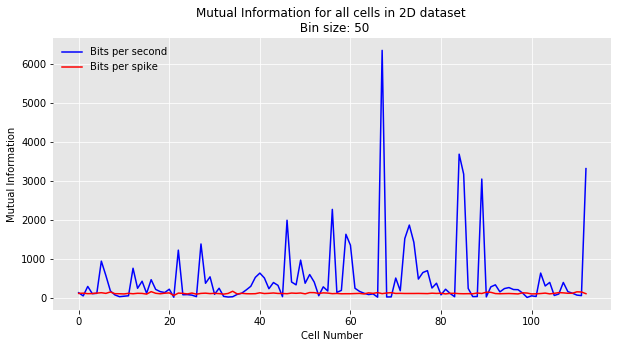

In [55]:
# plot mutual information 
plt.plot(all_bps2D, 'b-', label='Bits per second')
plt.plot(all_bpspk2D, 'r-', label='Bits per spike')
    
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Cell Number')
plt.ylabel('Mutual Information')
plt.title('Mutual Information for all cells in 2D dataset \n Bin size: %i' %bin2d)